## Lukasz Harazin: Getting historical prices 

Explores IronIA database to pick representative funds for each country selected for the algorithm. 
Then retrieves historical prices for selected funds to perform backtesting.

In [1]:
import pandas as pd
import numpy as np
from time import time
from matplotlib import pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
credentials = service_account.Credentials.from_service_account_file('harazinlt.json')
client = bigquery.Client(credentials=credentials)

### Exploring all available funds

In [97]:
sql = """SELECT isin,allfunds_id,short_name,manager_name,
            class_code,geo_zone,inception_at,modified_date,
            management_fee,ongoing_charges,performance_fee,purchase_fee,rebate
        FROM Ironia_Ext.instruments 
        WHERE available_ironia=True AND currency='EUR' AND asset_type = 'RVG'
            AND currency_hedge=False AND nomin=False AND income=False
        """
all_funds_RVG_EUR = client.query(sql).to_dataframe()
all_funds_RVG_EUR.index = all_funds_RVG_EUR['isin']
all_funds_RVG_EUR.head()

,isin,allfunds_id,short_name,manager_name,class_code,geo_zone,inception_at,modified_date,management_fee,ongoing_charges,performance_fee,purchase_fee,rebate
isin,,,,,,,,,,,,,
LU1893657210,LU1893657210,0164347,"THEAM QUANT EQUITY WO ""P"" (EUR) A",THEAM,P,EU,2019-11-08,2023-06-30,0.700,1.02,NaN,3.0,NaN
FR0013294725,FR0013294725,0054670,"CPR SILVER AGE ""R"" (EUR)",CPR AM,R,EU,2017-11-15,2023-06-30,0.794,1.01,15.0,3.0,NaN
LU0792910308,LU0792910308,0154642,"ROBECO EM MKT EQ ""F"" (EUR)",ROBECO,F,GEM,2012-07-04,2023-06-30,0.800,1.06,0.0,0.0,0.0000
LU0128640439,LU0128640439,0421003,"ROBECO EMERGING MARKETS EQUITIES ""M""",ROBECO,M,GEM,2001-09-03,2023-06-30,2.000,2.26,0.0,5.0,0.9900
LU0187076913,LU0187076913,0421046,"ROBECO EMERGING MARKETS EQUITIES ""D""",ROBECO,D,GEM,1994-09-29,2023-06-30,1.500,1.76,0.0,5.0,0.6188


In [98]:
# Filtering funds by geo_zone
all_funds_RVG_EUR.loc[(all_funds_RVG_EUR['geo_zone'] == 'FR') & (all_funds_RVG_EUR['ongoing_charges'] < 2) & (all_funds_RVG_EUR['inception_at'] < '2012-07-01')]

,isin,allfunds_id,short_name,manager_name,class_code,geo_zone,inception_at,modified_date,management_fee,ongoing_charges,performance_fee,purchase_fee,rebate
isin,,,,,,,,,,,,,
FR0007065743,FR0007065743,0282252,"SYCOMORE FRANCECAP ""A"" (EUR)",SYCOMORE ASSET MANAGEMENT (FR),A,FR,2001-10-30,2023-06-30,1.5,1.5,20.0,5.0,0.495
FR0010111724,FR0010111724,0282253,"SYCOMORE FRANCECAP ""I"" (EUR)",SYCOMORE ASSET MANAGEMENT (FR),I,FR,2001-10-30,2023-06-30,1.0,1.0,20.0,7.0,0.000


### Exploring various ratios

In [5]:
sql = """SELECT distinct ratio
        FROM Ironia_Ext.Ratios 
        WHERE allfunds_id = 0018110 AND date = '2023-08-16'
        ORDER BY ratio"""
ratios = client.query(sql).to_dataframe()
ratios

,ratio
0,alpha
1,bear_beta
2,beta
3,bull_beta
4,calmar
5,correlation
6,downside_deviation
7,information_ratio
8,linear_return
9,log_annualized_return


In [100]:
sql = """SELECT distinct benchmark_name
        FROM Ironia_Ext.Ratios AS R
                INNER JOIN Ironia_Ext.instruments AS I ON R.allfunds_id = CAST(I.allfunds_id AS INT)
        WHERE R.ratio = 'tracking_error' AND R.period = '3y' AND R.date = '2023-09-20' AND R.value_product < 0.1 AND
                available_ironia=True AND currency='EUR' AND currency_hedge=False AND nomin=False AND income=False
                AND management_fee < 1 AND asset_type = 'RVG'
        """
ratios = client.query(sql).to_dataframe()
ratios

,benchmark_name
0,MSCI Emerging Markets Europe Net Total Return ...
1,MSCI AC Asia Pacific Net Total Return USD Index
2,MSCI Turkey Net Index EUR
3,MSCI ACWI Net Total Return USD Index
4,MSCI Korea Net USD Index
5,MSCI India Net Total Return USD Index
6,Ibex 35
7,MSCI Canada Net Total Return USD Index
8,MSCI Europe Net Total Return
9,MSCI Pacific ex Japan Net Total Return USD Index


In [103]:
benchmark = 'MSCI Australia Net Total Return USD Index'

sql = f"""SELECT isin,short_name,manager_name,benchmark_name,
            class_code,geo_zone,inception_at,
            management_fee,ongoing_charges,performance_fee,
            R.allfunds_id, R.value_product
        FROM Ironia_Ext.Ratios AS R
                INNER JOIN Ironia_Ext.instruments AS I ON R.allfunds_id = CAST(I.allfunds_id AS INT)
        WHERE R.ratio = 'tracking_error' AND R.period = '3y' AND R.date = '2023-09-20' AND R.value_product < 0.1 AND
                available_ironia=True AND currency='EUR' AND currency_hedge=False AND nomin=False AND income=False
                AND management_fee < 1.5 AND ongoing_charges < 2 --AND (performance_fee IS NULL OR performance_fee = 0) 
                --AND benchmark_name = '{benchmark}'
        ORDER BY inception_at, R.value_product
        LIMIT 5
        """
low_tracking_error = client.query(sql).to_dataframe()
low_tracking_error

,isin,short_name,manager_name,benchmark_name,class_code,geo_zone,inception_at,management_fee,ongoing_charges,performance_fee,allfunds_id,value_product
0,LU0119195963,"GOLDMAN SACHS PATRIM ""P"" (EUR) B",GOLDMAN SACHS AM*,EQUILIBRADO,P,GLB,1977-12-01,1.20,1.53,NaN,142021,0.047008
1,FR0010172767,EDR - EURO SUSTAINABLE CRED A (EUR) ACC,EDMOND DE ROTHSCHILD ASSET MANAGEMENT,Bloomberg Barclays Euro Aggregate Corporate To...,A,EUR,1982-06-24,0.95,1.00,NaN,14803,0.013461
2,FR0000288946,"AXA COURT TERME ""A""",AXA INVESTMENT MANAGERS PARIS,EUROPEAN CENTRAL BANK EONIA INDEX 7 DAY,A,EUR,1984-03-08,0.06,0.07,0.0,62803,0.000245
3,LU0011889846,"JAN HH EUROLAND ""A2"" (EUR) ACC",JANUS HENDERSON HORIZON,EURO STOXX 50 Net Return EUR,A2,EUR,1984-07-02,1.20,1.86,10.0,503001,0.068345
4,LU0138643068,"DPAM L BD UNIV UNCONS ""B"" (EUR) ACC",DEGROOF PETERCAM ASSET SERVICES,Bloomberg Barclays Global-Aggregate Total Retu...,B,GLB,1985-01-01,0.80,1.00,NaN,368005,0.057657


### Selected funds - optimized for fees and index tracking

In [105]:
country_to_isin = {
    'United States': 'IE0032126645',
    'Japan': 'IE0007286036',
    'United Kingdom': 'IE00B7MSLV86',
    'Canada': 'LU1419797797',
    'Switzerland': 'LU0546268359',
    'Germany': 'LU0823428189',
    'Australia': 'LU0256781096',
    'Spain': 'ES0149051007',
    'Italy': 'LU0087656855',
    'Eurozone': 'IE0008248803',
    'China': 'LU0625737910',
    'India': 'LU0248271941',
    'Korea': 'LU0301637293',
    'Brazil': 'LU0616857586',
    'Turkiye': 'LU0823433775',
    'Russia': 'LU0625742753',
    'ACWI': 'IE00B62WCL09' # benchmark ACWI Index
} 

selected_funds = all_funds_RVG_EUR.loc[country_to_isin.values()]
selected_funds

,isin,allfunds_id,short_name,manager_name,class_code,geo_zone,inception_at,modified_date,management_fee,ongoing_charges,performance_fee,purchase_fee,rebate
isin,,,,,,,,,,,,,
IE0032126645,IE0032126645,0018110,VANGUARD U.S. 500 STOCK INDEX (EUR) ACC,VANGUARD INVESTMENT SERIES PLC,I,US,2002-09-26,2023-06-30,0.10,0.10,NaN,0.0,0.0000
IE0007286036,IE0007286036,0067444,VANGUARD JAPAN STOCK INDEX (EUR) ACC,VANGUARD INVESTMENT SERIES PLC,A,JP,2006-03-29,2023-06-30,0.16,0.16,NaN,0.0,0.0000
IE00B7MSLV86,IE00B7MSLV86,0228447,"ISHARES UK INDEX (IE) ""I"" (EUR) ACC",BLACKROCK INDEX SELECTION FUND,I,UK,1998-12-31,2023-06-30,0.15,0.17,NaN,NaN,0.0000
LU1419797797,LU1419797797,0002602,"CSIF (LUX) EQUITY CAN ""QB"" (EUR)",CS INVESTMENT FUNDS,QB,CA,2016-06-14,2023-06-30,0.15,0.10,NaN,2.0,0.0000
LU0546268359,LU0546268359,0086151,UBS (LUX) EQ - SWISS OPP P (EUR) ACC,UBS GLOBAL AM,P,CH,2010-11-16,2023-06-30,1.20,1.60,0.0,5.0,0.6138
LU0823428189,LU0823428189,0190575,"BNP GER MULTI-FACTOR EQ ""P"" (EUR) ACC",BNP PARIBAS INVESTMENT PARTNERS,P,DE,2013-05-24,2022-10-25,0.75,1.08,NaN,3.0,0.0000
LU0256781096,LU0256781096,0051017,"CANDRIAM EQS L AUSTRALIA ""I"" (EUR)",CANDRIAM LUX (CACEIS),I,AU,2007-03-26,2023-06-30,0.55,0.75,NaN,0.0,0.0000
ES0149051007,ES0149051007,0001821,"ABANCA IBEX 35 ""D"" (EUR)","ABANCA GESTION DE ACTIVOS, S.G.I.I.C",D,ES,2016-06-10,2023-06-30,0.35,0.47,NaN,NaN,0.1588
LU0087656855,LU0087656855,0015646,"AXA WF ITALY EQUITY ""F"" (EUR)",AXA INVESTMENT MANAGERS,F,IT,1998-05-01,2023-06-30,0.75,1.00,0.0,2.0,0.0000


### Retrieving historical prices since 2013

In [10]:
sql = """SELECT date, nav 
        FROM Ironia_Ext.Navs 
        WHERE allfunds_id = 0088006
        ORDER BY date"""
prices = client.query(sql).to_dataframe()
prices

,date,nav
0,2011-01-26,10.340000
1,2011-02-03,10.499000
2,2011-02-15,10.695895
3,2011-02-16,10.754890
4,2011-02-17,10.767325
...,...,...
3008,2023-08-16,36.411228
3009,2023-08-17,36.178465
3010,2023-08-18,36.177785
3011,2023-08-21,36.292887


In [11]:
df_prices = pd.DataFrame(index=pd.date_range('2013-01-02', '2023-08-23', freq='B'))
for isin in selected_funds.index:
    allfunds_id = selected_funds.loc[isin].loc['allfunds_id']

    sql = f"""SELECT * 
            FROM Ironia_Ext.Navs 
            WHERE allfunds_id = {allfunds_id}
            ORDER BY date"""
    prices = client.query(sql).to_dataframe()
    prices.index = pd.DatetimeIndex(prices['date'])
    prices = prices[~prices.index.duplicated(keep='first')]
    df_prices[isin] = prices['nav']

df_prices

,IE0032126645,IE0008248803,IE0007286036,LU0679964535,LU0625737910,LU0248271941,LU0301637293,LU0616857586,IE00B62WCL09
2013-01-02,11.5218,121.2740,103.2641,87.03,77.29,16.86,8.14,104.49,11.593814
2013-01-03,11.6241,121.0621,104.7968,87.15,79.45,17.06,8.20,105.44,11.695514
2013-01-04,11.7256,121.3894,107.3677,87.51,81.05,16.95,8.17,105.96,11.789624
2013-01-07,11.6408,120.7851,106.3010,87.42,81.20,16.87,8.19,105.82,11.713590
2013-01-08,11.6350,120.5640,106.1076,87.18,80.82,16.91,8.12,104.73,11.704624
...,...,...,...,...,...,...,...,...,...
2023-08-17,47.7749,263.7527,233.0415,155.14,107.28,44.00,12.86,176.37,36.178465
2023-08-18,47.8402,262.6807,233.1748,153.08,104.89,44.00,12.84,175.44,36.177785
2023-08-21,48.1075,263.2737,231.4313,153.84,102.87,44.15,12.79,174.38,36.292887
2023-08-22,48.1377,265.2265,235.6071,154.12,104.25,44.50,12.97,177.45,36.399962


In [12]:
df_prices = df_prices.ffill()
df_prices.to_csv('Data/Funds_Prices_2013-2023.csv')
df_prices

,IE0032126645,IE0008248803,IE0007286036,LU0679964535,LU0625737910,LU0248271941,LU0301637293,LU0616857586,IE00B62WCL09
2013-01-02,11.5218,121.2740,103.2641,87.03,77.29,16.86,8.14,104.49,11.593814
2013-01-03,11.6241,121.0621,104.7968,87.15,79.45,17.06,8.20,105.44,11.695514
2013-01-04,11.7256,121.3894,107.3677,87.51,81.05,16.95,8.17,105.96,11.789624
2013-01-07,11.6408,120.7851,106.3010,87.42,81.20,16.87,8.19,105.82,11.713590
2013-01-08,11.6350,120.5640,106.1076,87.18,80.82,16.91,8.12,104.73,11.704624
...,...,...,...,...,...,...,...,...,...
2023-08-17,47.7749,263.7527,233.0415,155.14,107.28,44.00,12.86,176.37,36.178465
2023-08-18,47.8402,262.6807,233.1748,153.08,104.89,44.00,12.84,175.44,36.177785
2023-08-21,48.1075,263.2737,231.4313,153.84,102.87,44.15,12.79,174.38,36.292887
2023-08-22,48.1377,265.2265,235.6071,154.12,104.25,44.50,12.97,177.45,36.399962


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a Dat

<Axes: >

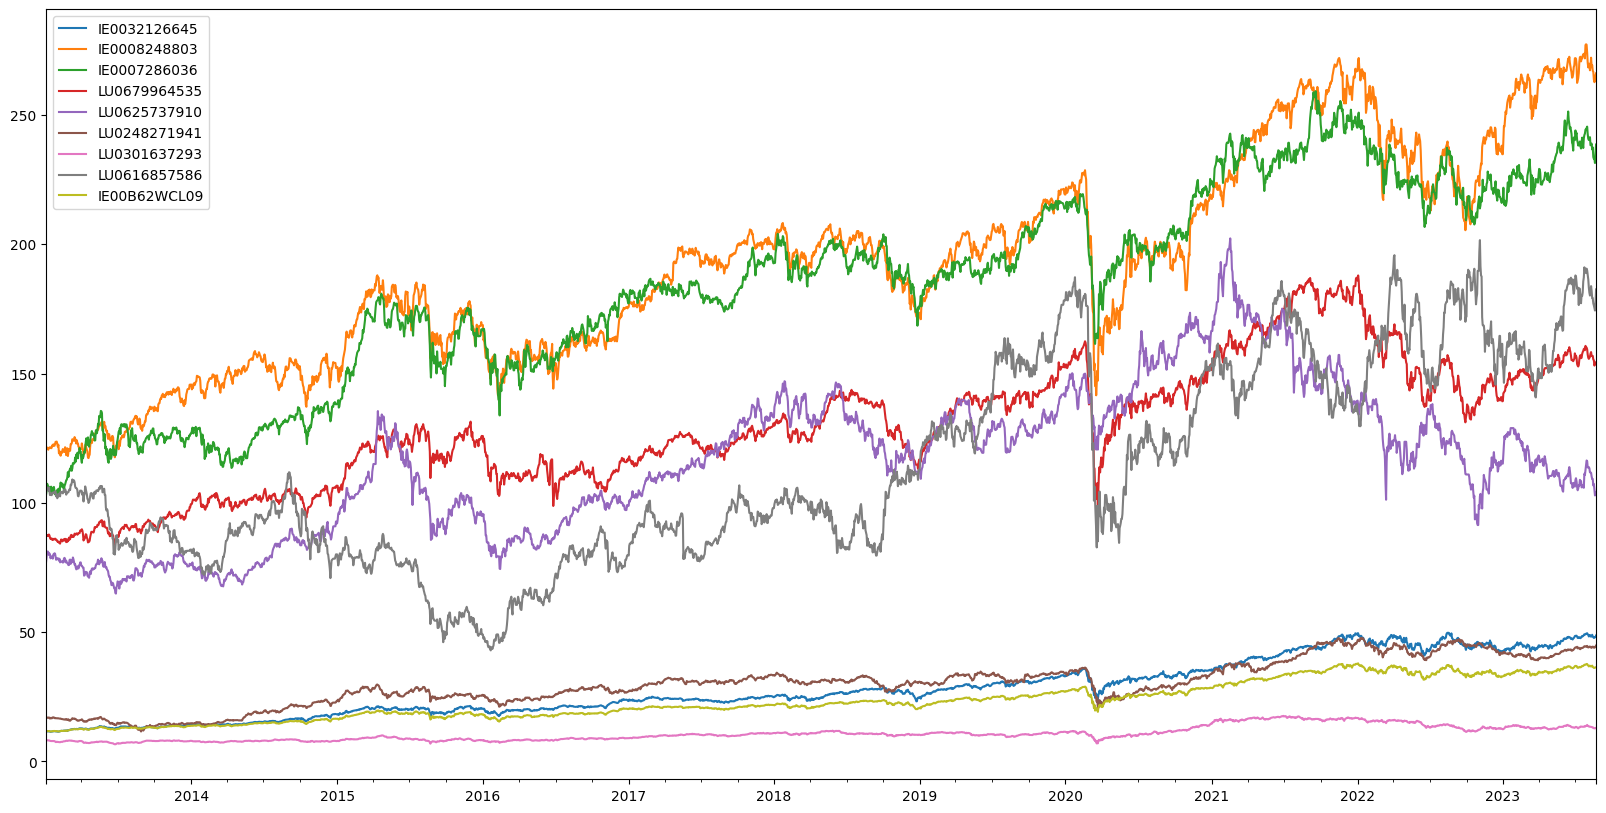

In [13]:
df_prices.plot(figsize=(20,10))

### Exploring returns and sharpe ratios

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a Dat

<Axes: >

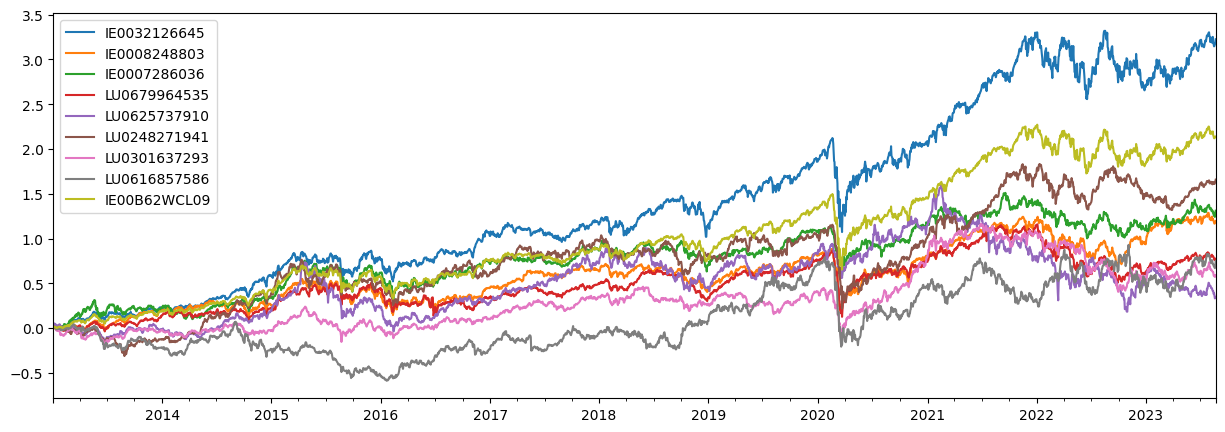

In [14]:
daily_returns = df_prices.pct_change()
cum_returns = ((daily_returns + 1).cumprod() - 1)
cum_returns.plot(figsize=(15, 5))

In [15]:
def daily_to_annual_returns(daily_returns):
    daily_returns.iloc[0] = 0
    tot_ret = (daily_returns + 1).prod() - 1

    #sim_tot_ret = (df_prices.iloc[-1]/df_prices.iloc[0])-1 # Alternativa
    
    init_date = daily_returns.index[0]
    end_date = daily_returns.index[-1]
    fyears = (end_date - init_date) / pd.Timedelta(days=365, hours=6) # Calculamos el nº de años que contiene la serie que hemos pasado
    #print('Years:',fyears)
    
    anual_ret = np.power(tot_ret + 1, 1/fyears) - 1  # lo anualizamos (raíz enésima: 1 partido el cálculo que se muestra)
    return anual_ret

In [16]:
def get_annual_summary(df_prices):
    daily_returns = df_prices.pct_change()
    annual_returns = daily_to_annual_returns(daily_returns)
    annual_volatility = daily_returns.std()*np.sqrt(252)

    annual_summary = pd.DataFrame()
    annual_summary['Return'] = annual_returns
    annual_summary['Volatility'] = annual_volatility
    annual_summary['Sharpe'] = annual_returns/annual_volatility
    return annual_summary

In [17]:
get_annual_summary(df_prices)

,Return,Volatility,Sharpe
IE0032126645,0.145102,0.183746,0.789690
IE0008248803,0.076681,0.178332,0.429992
IE0007286036,0.081910,0.179361,0.456677
LU0679964535,0.055377,0.174951,0.316531
LU0625737910,0.028439,0.233885,0.121592
LU0248271941,0.096254,0.206130,0.466958
LU0301637293,0.044086,0.199732,0.220728
LU0616857586,0.053860,0.335489,0.160541
IE00B62WCL09,0.113561,0.151084,0.751638
